# Weather

In [1]:
import helpers as hp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import normaltest
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine
import statsmodels.api as sm

import warnings
warnings.filterwarnings(action="ignore")

from config import usr, pwd, url, port, db

%matplotlib inline

## Load Data
Load the dataset and inspect it's contents.

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {db};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


### Target Variable
The target variable is the difference betweem _temperature_ and _apparenttemperature_.

In [7]:
df['temp_diff'] = df['apparenttemperature'] - df['temperature']

## Part 1
Only consider the following columns for this analysis.

In [8]:
columns = ['humidity', 'windspeed', 'temp_diff']

In [9]:
df_subset_1 = df.loc[:, columns].copy()

In [10]:
df_subset_1.describe().T

,count,mean,std,min,25%,50%,75%,max
humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.7800,0.8900,1.000000
windspeed,96453.0,10.810640,6.913571,0.000000,5.828200,9.9659,14.1358,63.852600
temp_diff,96453.0,-1.077650,1.678694,-10.183333,-2.216667,0.0000,0.0000,4.811111


In [11]:
df_subset_1.corr()

,humidity,windspeed,temp_diff
humidity,1.000000,-0.224951,-0.242212
windspeed,-0.224951,1.000000,-0.411943
temp_diff,-0.242212,-0.411943,1.000000


### Modeling

In [12]:
features = ['humidity', 'windspeed']
X = df_subset_1.loc[:, features]
y = df_subset_1['temp_diff']

X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              temp_diff   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                 1.949e+04
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        15:38:06   Log-Likelihood:            -1.7046e+05
No. Observations:               96453   AIC:                         3.409e+05
Df Residuals:                   96450   BIC:                         3.409e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4381      0.021    115.948      0.0

**Observations:**

The p-value for the coefficients is much less than 0.05, indicating that the coefficients are statistically significant. Both coefficients have negative signs. This indicates that if the windspeed or humidity increase, the temperature will go down, which makes sense.

## Part 2
Create an interaction term between _humidity_ and _windspeed_, re-run the model, and interpret the results.

In [13]:
df_subset_2 = df_subset_1.copy()

In [14]:
df_subset_2['humid_wind'] = df_subset_2['humidity']*df_subset_2['windspeed']

In [15]:
df_subset_2.describe().T

,count,mean,std,min,25%,50%,75%,max
humidity,96453.0,0.734899,0.195473,0.000000,0.600000,0.780000,0.89000,1.000000
windspeed,96453.0,10.810640,6.913571,0.000000,5.828200,9.965900,14.13580,63.852600
temp_diff,96453.0,-1.077650,1.678694,-10.183333,-2.216667,0.000000,0.00000,4.811111
humid_wind,96453.0,7.640729,5.034842,0.000000,3.820852,6.701464,10.21384,43.346835


In [16]:
df_subset_2.corr()

,humidity,windspeed,temp_diff,humid_wind
humidity,1.000000,-0.224951,-0.242212,0.200929
windspeed,-0.224951,1.000000,-0.411943,0.875213
temp_diff,-0.242212,-0.411943,1.000000,-0.560843
humid_wind,0.200929,0.875213,-0.560843,1.000000


### Modeling

In [20]:
features = ['humidity', 'windspeed', 'humid_wind']
X = df_subset_2.loc[:, features]
y = df_subset_2['temp_diff']

X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              temp_diff   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                 1.666e+04
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:19:54   Log-Likelihood:            -1.6669e+05
No. Observations:               96453   AIC:                         3.334e+05
Df Residuals:                   96449   BIC:                         3.334e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0839      0.033      2.511      0.0

In [22]:
print(results.params)

const         0.083936
humidity      0.177512
windspeed     0.090482
humid_wind   -0.297119
dtype: float64


In [21]:
print(results.pvalues)

const          1.202772e-02
humidity       3.577458e-05
windspeed     2.279327e-294
humid_wind     0.000000e+00
dtype: float64


In [25]:
df_test = pd.concat([results.params, results.pvalues], axis=1)
df_test.reset_index(inplace=True)
df_test.columns = ['feature', 'coeff', 'pvalue']

In [26]:
df_test

,feature,coeff,pvalue
0,const,0.083936,1.202772e-02
1,humidity,0.177512,3.577458e-05
2,windspeed,0.090482,2.279327e-294
3,humid_wind,-0.297119,0.000000e+00


**Observations:**

All coefficients are statistically significant. The coefficients for _humidity_ and _windspeed_ switched signs. The new, interaction term, _humid\__wind_ has a negative sign. The coefficient for _humid\__wind_ lies between the coefficients for _humidity_ and _windspeed_ from the first model. This is because _humid\__wind_ describes the averaged effect for both _humidity_ and _windspeed_.

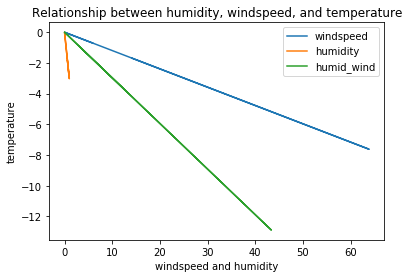

In [18]:
y_windspeed = -0.1193*df_subset_1['windspeed']
y_humidity = -3.0292*df_subset_1['humidity']
y_humid_wind = -0.2971*df_subset_2['humid_wind']

plt.plot(df_subset_1['windspeed'], y_windspeed)
plt.plot(df_subset_1['humidity'], y_humidity)
plt.plot(df_subset_2['humid_wind'], y_humid_wind)
plt.legend(['windspeed', 'humidity', 'humid_wind'])
plt.xlabel('windspeed and humidity')
plt.ylabel('temperature')
plt.title('Relationship between humidity, windspeed, and temperature')
plt.show()